## Regression Analysis of *__ADR__ (Average Daily Rate)*

> In this notebook, we will optimize a regression model to predict __adr__ price based on rest of the features.


In [4]:
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D

## Model Analysis

Apply model analysis to prepared data from Data Prep notebook.

In [5]:
X_train_norm_reg_kbest = pd.read_pickle('X_train_norm_reg_kbest.pkl')
X_test_norm_reg_kbest = pd.read_pickle('X_test_norm_reg_kbest.pkl')
y_train_reg = pd.read_pickle('y_train_reg.pkl')
y_test_reg = pd.read_pickle('y_test_reg.pkl')


### Parameter Tuning - Grid-Search CV
Performing GridSearchCV on each regression model in a loop to discover their best parameters and scores __RMSE__, __MAE__. These scores will be used to determine which one is the best performing model for price prediction (__adr__)
We explore the following regression models:
> - __Linear Regression__
> - __Stochastic Gradient Descent Regression__
> - __Elastic Net__
> - __SVR__
> - __Ada Boost Regression__
> - __Gradient Boost Regression__
> - __Random Forest Regression__
> - __K Neighbors Regression__

In [25]:
# assisting functions for GridSearch
##----------------------------------##
def perform_grid_search(model, param_grid, X_train, X_test, y_train):
    
    grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)
    
    best_model = grid.fit(X_train, y_train)
    print('##----------------------------##')
    print('Model: ', best_model.estimator)
    print('Best Parameters: ', best_model.best_params_)
    
    y_predict = best_model.predict(X_test)

    return y_predict

def show_regression_scores(y_test, y_predict):
    
    rmse = np.sqrt(mean_squared_error(y_test.values, y_predict))
    mae = mean_absolute_error(y_test.values, y_predict)
    
    print("RMSE", rmse)
    print("MAE", mae)
    
    return (rmse, mae)
##--------------------------------------------##

In [8]:
# GridSearchCVs
warnings.filterwarnings('ignore')

lr = LinearRegression()
lr_params = {}
criterion = ["mse", "mae"]

# SGDRegressor
sgdr = SGDRegressor(max_iter=10, tol=1e-3, penalty="l2")
sgdr_params = {"max_iter": [50, 100, 150], "tol": [1e-1, 1e03, -np.infty], "penalty": ["l2", "l1", "elasticnet"]}

# DecisionTreeRegressor - Not completed due to slow machine (took one day, still going)
"""
dcr = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
dcr_params = {"criterion": criterion, "min_samples_split": [10, 20, 30], "max_depth": [2, 4, 6], "min_samples_leaf": [10, 20, 30], "max_leaf_nodes": [20, 30, 40] }
"""

# ElasticNet
en = ElasticNet(max_iter = 1, alpha = 1, l1_ratio = 0.0)    
en_params = {"max_iter": [1, 5, 10], "alpha": [0.001, 0.01, 0.1, 1], "l1_ratio": np.arange(0.0, 1.0, 0.1)}

# SVR
svr = SVR(kernel = 'rbf', gamma = 0.1)
svr_params = {"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}

# KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=3)
knr_params = { "n_neighbors": [3,6,9,12]}

# AdaBoostRegressor
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
abr_params = {"n_estimators": (1, 2), "base_estimator__max_depth": (1, 2)}

# GradientBoostingRegressor - Not completed due to slow machine (took one day, still going)
"""
gbr = GradientBoostingRegressor(max_depth = 2, warm_start = True, random_state = 42, n_estimators = 12, learning_rate = 0.1)
gbr_params = {"criterion": criterion, "max_depth": [2,4,6]}
"""
# RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1, bootstrap = True, max_depth = 5, random_state = 42)
rfr_params = {"criterion": criterion, "n_estimators": [2,3,4]}

# Put all models in an array with their related model to make predictions
model_tups = [(lr, lr_params), (sgdr, sgdr_params), (en, en_params), 
              (knr, knr_params), (abr, abr_params), (rfr, rfr_params)]

df_results = pd.DataFrame(columns = ["RMSE", "MAE"])

for model_tup in model_tups:
    
    model_name = type(model_tup[0]).__name__
    
    y_predict = perform_grid_search(model_tup[0], model_tup[1], X_train_norm_reg_kbest, X_test_norm_reg_kbest, y_train_reg)

    result = show_regression_scores(y_test_reg, y_predict)
    
    sresult = pd.Series({"RMSE": result[0], "MAE": result[1]}, name= model_name)

    df_results = df_results.append(sresult)

df_results


##----------------------------##
Model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Best Parameters:  {}
RMSE 27.60742311687622
MAE 20.400134907909642
##----------------------------##
Model:  SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Best Parameters:  {'max_iter': 150, 'penalty': 'l1', 'tol': -inf}
RMSE 27.607213035002797
MAE 20.42846519856411
##----------------------------##
Model:  ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.0, max_iter=1,
           normalize=False, positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)
B

,RMSE,MAE
LinearRegression,27.607423,20.400135
SGDRegressor,27.607213,20.428465
ElasticNet,27.605143,20.454570
KNeighborsRegressor,21.487599,13.167343
AdaBoostRegressor,36.953012,28.855420
RandomForestRegressor,29.919403,22.742184


Plotting RMSE and MAE values for __adr__ from each model.

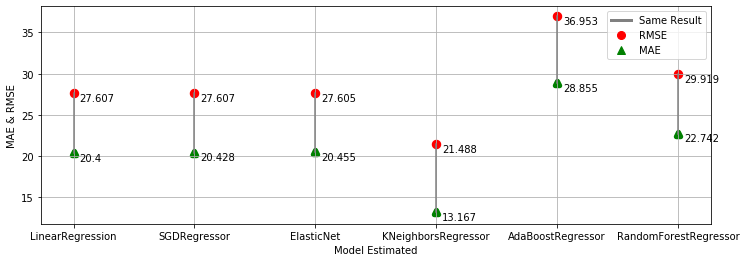

In [165]:
df_regression_results = pd.read_pickle("df_regression_results.pkl")
df_regression_results['model'] = np.arange(len(df_regression_results))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
df_regression_results.plot.scatter(x= 'model', y = 'RMSE', ax = ax, color='r', marker ='o', linewidths=5)
df_regression_results.plot.scatter(x= 'model', y = 'MAE', ax = ax, color='g', marker='^', linewidth=5)

ax.set_xticks(np.arange(df_regression_results.size))
ax.set_xticklabels(df_regression_results.index.values, rotation = 0)
ax.set_xlabel('Model Estimated')
ax.set_ylabel('MAE & RMSE')

for index, row in df_regression_results.iterrows():
    plt.plot([row['model'], row['model']],[row['RMSE'],row['MAE']],color='grey')
    plt.annotate(round(row['MAE'], 3), xy=(row['model'] + 0.05, row['MAE']), ha="left", va="top")
    plt.annotate(round(row['RMSE'], 3), xy=(row['model'] + 0.05, row['RMSE']), ha="left", va="top")

legend_elements = [Line2D([0], [0], color='grey', lw=3, label='Same Result'),
                   Line2D([0], [0], marker='o', color='r', label='RMSE',markerfacecolor='r', markersize=8,linestyle=''),
                   Line2D([0], [0], marker='^', color='g', label='MAE',markerfacecolor='g', markersize=8, linestyle='')]
ax.legend(handles=legend_elements, loc='top-right')
plt.grid()

### Parameter Tuning - Single Model
As we can notice from the model above, __KNeighborsRegressor__ performed the best. It is not a surprise because KNN Regression performs well when a large number of features explain equally small amount of covariance in target variable, yet none of the feature variables have siginificant covariance with target as explained here:
https://stats.stackexchange.com/questions/104255/why-would-anyone-use-knn-for-regression

We will explore that model further to get most accurate __MAE__ and __RMSE__ value possible.
The idea is to select range of values for avaiable __hyper parameters__ in such a way that the best model hyper parameter values are in the middle of the value range. By exprimenting with various parameters values (parameter tuning), we found out the following:

> - Hyper parameter __p__ is only allowed to have values __1__ or __2__, that's why values are limited to that range.
> - Hyper parameter __n_neighbors__ is likely to have optimal values between __1__ to __5__, hence range is [1,2,3,4,5]
> - Hyper parameter __leaf_size__ is expected to have optimal values between __25__ to __35__

In [24]:
X_train_norm_reg_kbest = pd.read_pickle('X_train_norm_reg_kbest.pkl')
X_test_norm_reg_kbest = pd.read_pickle('X_test_norm_reg_kbest.pkl')
y_train_reg = pd.read_pickle('y_train_reg.pkl')
y_test_reg = pd.read_pickle('y_test_reg.pkl')

knr = KNeighborsRegressor(n_neighbors=3, n_jobs=6)
knr_params = { "n_neighbors": [1,2,3,4,5], "leaf_size": [25, 30, 35], "p": [1, 2]}

grid = GridSearchCV(estimator = knr, param_grid = knr_params, cv = 3)

best_model = grid.fit(X_train_norm_reg_kbest, y_train_reg)

y_predict = best_model.predict(X_test_norm_reg_kbest)
result = show_regression_scores(y_test_reg, y_predict)
print(result)

RMSE 21.563090526225196
MAE 13.130964521836297
(21.563090526225196, 13.130964521836297)


In [26]:
best_model

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=6,
                                           n_neighbors=3, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'leaf_size': [25, 30, 30],
                         'n_neighbors': [1, 2, 3, 4, 5], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

As we can notice, __best_model__ has chosen values for __leaf_size=30__ and __n_neighbours=3__. These values are inbetween the range provided for these hyper parameters, therefore, we can be confident that the values are most optimal for our data.

<hr>

Lets draw a __actual vs predicted__ graph. It should have even distribution of values around the middle disecting line if the model is a good predictor.

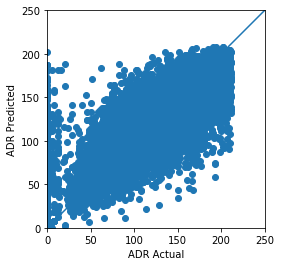

In [31]:
plt.figure(figsize=(20,4))
plt.axes(aspect='equal')
plt.scatter(y_test_reg, y_predict)
plt.xlabel('ADR Actual')
plt.ylabel('ADR Predicted')
lims = [0, 250]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

In [39]:
df_results = pd.DataFrame({"Actual": y_test_reg, "Predicted": y_predict})
df_results['idx'] = df_results.index.values


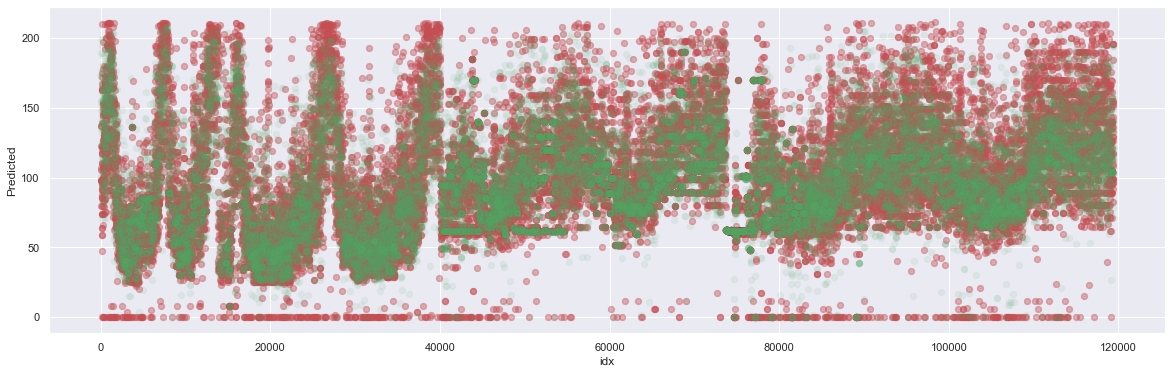

In [46]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)

df_results.sort_index().plot.scatter(x= 'idx', y = 'Actual', ax = ax, color='r', marker ='.', linewidths=5, alpha=0.5)
df_results.sort_index().plot.scatter(x= 'idx', y = 'Predicted', ax = ax, color='g', marker='.', linewidth=5, alpha=0.1)



